In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap, ScalarMappable
import matplotlib.colors as colors
import numpy as np

In [40]:
config = {
    "recovery_time": 4,
    "incubation_time": 2,
    "transmission_probability": 0.8,
    "death_rate": 0.03,
    "hospital_capacity": 0.06,
}

In [3]:
class Agent:
    statuses = ["healthy", "carrying", "sick", "dead", "recovered"]
    
    def __init__(self, index = None, status=statuses[0], strategy={"healthy": 1}):
        self.index = index
        self.status = status
        self.infection_time = 0
        self.carrying_time = 0
        self.strategy = strategy
        self.distancing_factor = strategy["healthy"]  # social distancing, 0 = total isolation, 1 = no distancing
        
    def __str__(self):
        return self.status
    
    def __repr__(self):
        return self.__str__()
    
    def interact(self, other_status, other_df):
        if self.status == "healthy" and (other_status == "sick" or other_status == "carrying"):
            p = np.random.rand(3)
            if p[0] < config["transmission_probability"] and p[1] < self.distancing_factor and p[2] < other_df:
                self.status = "carrying"  # change_df() not called because agent can't distinguish healthy vs. carrying
    
    def step(self):
        if self.status == "carrying":
            self.carrying_time += 1
            if self.carrying_time > config["incubation_time"]:
                self.status = "sick"
                self.change_df()
        if self.status == "sick":
            self.infection_time += 1
            if self.infection_time > config["recovery_time"]:
                self.status = "recovered"
                self.change_df()
            p = np.random.random()
            if p < config["death_rate"]:
                self.status = "dead" 
                
    def change_df(self):
        if self.status in self.strategy.keys():
            self.distancing_factor = self.strategy[self.status]

In [4]:
def random_pairs(pop): #takes list of length N and returns floor(N/2) random pairs of indices 
    # filter out dead population (they don't interact)
    living = []
    for a in pop:
        if a.status !="dead":
            living.append(a)
            
    # if length is odd, last entry is just ignored
    size = len(living)
    if size % 2 == 1: 
        size -= 1
        living = living[0:-1]
    
    halfway = int(size/2)
    indices = np.array([a.index for a in living])
    
    # shuffle the list, break in half, align to each other, then transpose for pairs
    np.random.shuffle(indices)
    partition_1 = indices[0 : halfway]
    partition_2 = indices[halfway : size]
    
    lineup = np.stack([partition_1, partition_2])
    
    pairs = np.transpose(lineup)  
        
    return pairs


def infection_step(population):
    pairs = random_pairs(population)
    
    for pair in pairs:
        agentA = population[pair[0]]
        agentB = population[pair[1]]
            
        population[pair[0]].interact(agentB.status, agentB.distancing_factor)
        population[pair[1]].interact(agentA.status, agentA.distancing_factor)
            
        for i in range(2):
            population[pair[i]].step()
        
    return population

In [5]:
simulation_config = {
    "population_size": 600,
    "strategy": {"healthy": 0.8, "sick": 0.3}
}

sc = simulation_config

In [43]:
def simulate_pandemic(population_size, infected_frac=0.01, step_count=60, df2 = None, t_d = None, strategy=sc["strategy"]): 
    # some awkward control logic
    td = (step_count + 1) if (t_d == None) else t_d
    df2 = strategy['healthy'] if (df2 == None) else df2
    
    infected_size = int(population_size*infected_frac)
    population = np.array([Agent(index=i, strategy=strategy) for i in range(population_size)])
    for i in range(infected_size):
        population[i].status = "sick"  # initial sick patients

    carrying = np.array(0)
    sick = np.array([infected_size])
    recovered = np.array([0])
    dead = np.array([0])

    for i in range(step_count):        
        infection_step(population)
        stats = {"healthy": 0, "carrying":0, "sick": 0, "dead": 0, "recovered": 0}
        
        # distancing factor df2 is enforced at timestep td
        for a in population:
            if i == td:
                a.distancing_factor = df2 if a.distancing_factor > df2 else a.distancing_factor
            stats[a.status] += 1
            
        carrying = np.append(carrying, stats['carrying'])
        sick = np.append(sick, stats['sick'])
        recovered = np.append(recovered, stats['recovered'])
        dead = np.append(dead, stats['dead'])
        
        if stats['sick']/population_size > config["hospital_capacity"]:
            config["death_rate"] = 0.1
        else:
            config['death_rate'] = 0.03

    time = [i for i in range(step_count + 1)]

    carrying = carrying/float(population_size)
    sick = sick/float(population_size)
    recovered = recovered/float(population_size)
    dead = dead/float(population_size)
    
    return [time, carrying, sick, dead, recovered]

In [44]:
cm = get_cmap("twilight")
colors = [cm(i/4.0) for i in range(4)]

In [47]:
steps = 50
size = 900
strategy1 = {'healthy': 0.8, 'sick':0.3, 'recovered': 1.0}
strategy2 = {'healthy': 0.8, 'sick':0.6, 'recovered': 1.0}
strategy3 = {'healthy': 0.6, 'sick':0.3, 'recovered': 1.0}
strategy4 = {'healthy': 0.6, 'sick':0.6, 'recovered': 1.0}
stats_00 = simulate_pandemic(size, step_count=steps, strategy = strategy1)
stats_01 = simulate_pandemic(size, step_count=steps, strategy = strategy2)
stats_10 = simulate_pandemic(size, step_count=steps, strategy = strategy3)
stats_11 = simulate_pandemic(size, step_count=steps, strategy = strategy4)

stat_matrix = [[stats_00, stats_01], [stats_10, stats_11]]

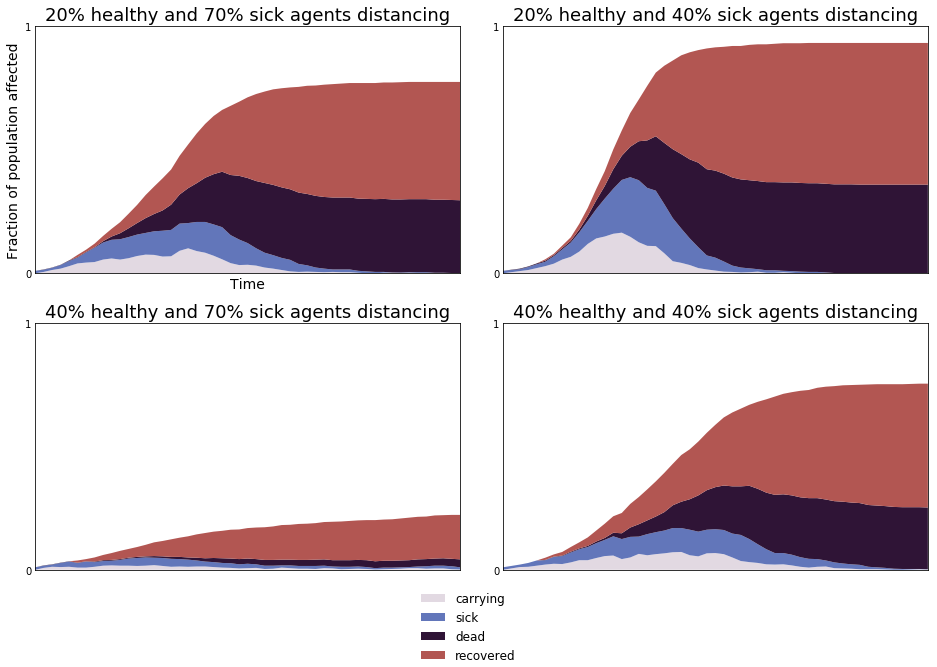

In [49]:
fig, axes = plt.subplots(2,2, figsize=(16, 10), gridspec_kw={"wspace":0.1})

for i in range(2):
    for j in range(2):
        axes[i][j].stackplot(stat_matrix[i][j][0], stat_matrix[i][j][1:], labels=Agent.statuses[1:], colors=colors)
        #axes[i][j].plot([0,steps], [config["hospital_capacity"], config["hospital_capacity"]], color='red')
        
        axes[i][j].tick_params(length=0)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([0, 1])
        axes[i][j].set_ylim((0, 1))
        axes[i][j].set_xlim((0, len(stat_matrix[0][0][0])-1))

axes[0][0].set_title("20% healthy and 70% sick agents distancing", fontsize=18)
axes[0][1].set_title("20% healthy and 40% sick agents distancing", fontsize=18)
axes[1][0].set_title("40% healthy and 70% sick agents distancing", fontsize=18)
axes[1][1].set_title("40% healthy and 40% sick agents distancing", fontsize=18)

axes[0][0].set_xlabel("Time", fontsize=14)
axes[0][0].set_ylabel("Fraction of population affected", fontsize=14)

fig.legend(labels=Agent.statuses[1:], edgecolor='white', fontsize=12, loc='lower center', borderaxespad=0, framealpha=0)

In [11]:
fig.savefig("images/Pandemic.png")

In [12]:
### ==================================== Enforced distancing ==================================== ###

In [10]:
steps = 45
size = 900
t_d = 5

strategy1 = {'healthy': 1.0, 'sick':0.2, 'recovered': 1.0}

stats_00 = simulate_pandemic(size, step_count=steps, strategy = strategy1)
stats_01 = simulate_pandemic(size, step_count=steps, strategy = strategy1, df2=0.8, t_d=t_d)
stats_10 = simulate_pandemic(size, step_count=steps, strategy = strategy1, df2=0.65, t_d=t_d)
stats_11 = simulate_pandemic(size, step_count=steps, strategy = strategy1, df2=0.5, t_d=t_d)

stat_matrix = [[stats_00, stats_01], [stats_10, stats_11]]

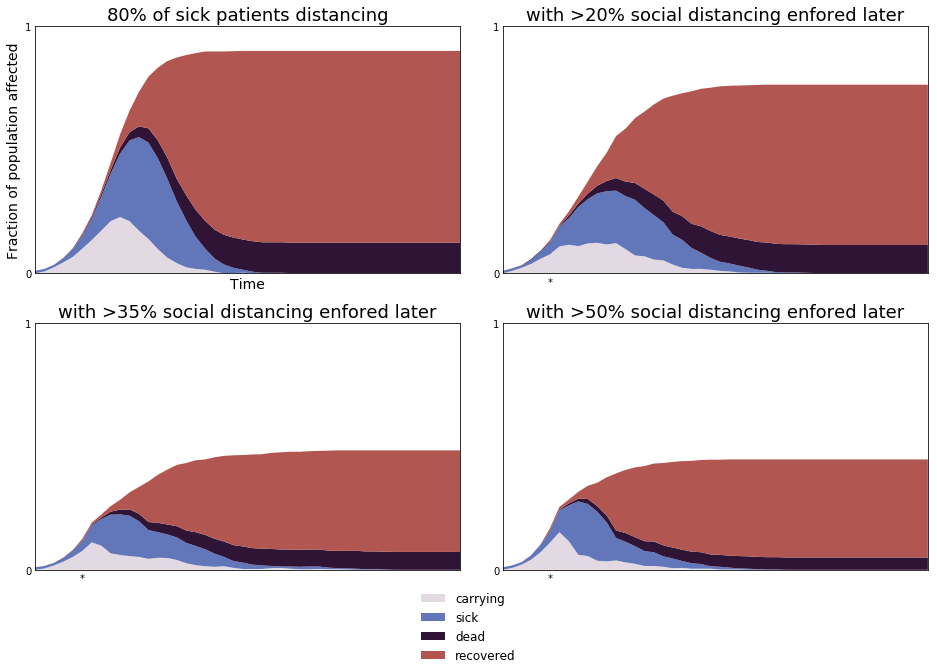

In [11]:
fig, axes = plt.subplots(2,2, figsize=(16, 10), gridspec_kw={"wspace":0.1})

for i in range(2):
    for j in range(2):
        axes[i][j].stackplot(stat_matrix[i][j][0], stat_matrix[i][j][1:], labels=Agent.statuses[1:], colors=colors)
        
        axes[i][j].tick_params(length=0)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([0, 1])
        axes[i][j].set_ylim((0, 1))
        axes[i][j].set_xlim((0, len(stat_matrix[0][0][0])-1))

axes[0][0].set_title("80% of sick patients distancing", fontsize=18)
axes[0][1].set_title("with >20% social distancing enfored later", fontsize=18)
axes[1][0].set_title("with >35% social distancing enfored later", fontsize=18)
axes[1][1].set_title("with >50% social distancing enfored later", fontsize=18)

axes[0][0].set_xlabel("Time", fontsize=14)
axes[0][0].set_ylabel("Fraction of population affected", fontsize=14)

axes[0][1].set_xticks([t_d])
axes[1][0].set_xticks([t_d])
axes[1][1].set_xticks([t_d])

axes[0][1].set_xticklabels(['*'])
axes[1][0].set_xticklabels(['*'])
axes[1][1].set_xticklabels(['*'])

fig.legend(labels=Agent.statuses[1:], edgecolor='white', fontsize=12, loc='lower center', borderaxespad=0, framealpha=0)

In [14]:
fig.savefig("images/Distancing.png")

In [1]:
### ============================ Flattening the curve ============================ ###

In [27]:
steps = 90
size = 3000
res = 10

cm2 = get_cmap("viridis")
colors2 = [cm2(i/(res+1)) for i in range(res+1)]

In [28]:
config["recovery_time"] = 8
config["incubation_time"] = 6
config["death_rate"] = 0.04
config["transmission_probability"] = 0.4

In [35]:
strategy = {'healthy': 1.0, 'sick':0.3, 'recovered': 1.0}
df2_list = [0.3 + i*(1 - 0.3)/res for i in range(res+1)]
t_d_list = [i for i in range(5,5+res)]

stats = [simulate_pandemic(size, step_count=steps, strategy = strategy, t_d=6, df2=d) for d in df2_list]

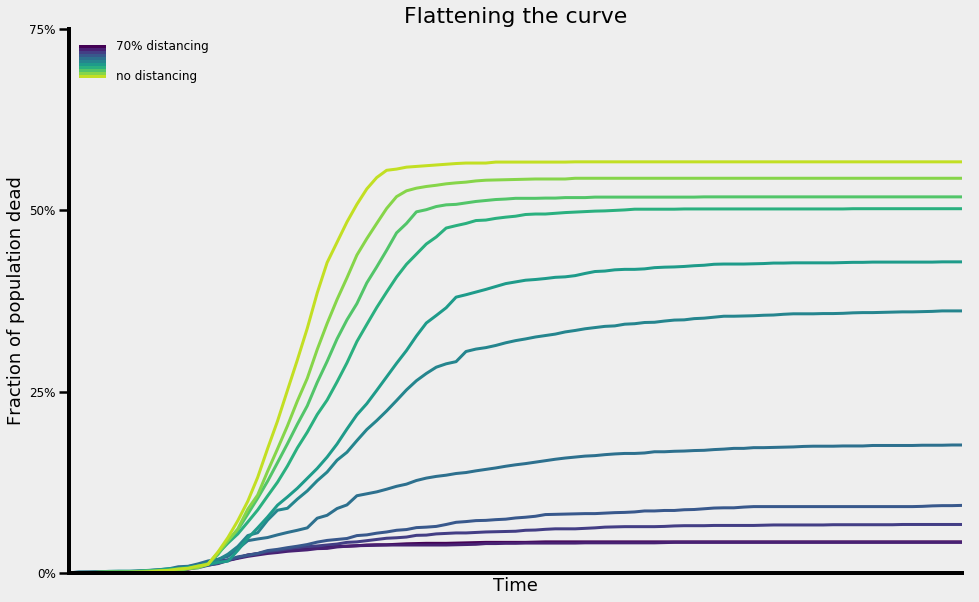

In [36]:
fig, axes = plt.subplots(figsize=(16,10))

fig.patch.set_facecolor("#eeeeee")
axes.set_facecolor("#eeeeee")

axes.tick_params(length=10, width=2.5, labelsize=12)
for key in axes.spines.keys():
    axes.spines[key].set_linewidth(4)
    axes.spines[key].set_color("#000000")

axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)

axes.set_xlabel("Time", fontsize=18)
axes.set_ylabel("Fraction of population dead", fontsize=18)
axes.set_xlim(0, steps)
axes.set_ylim(0, 0.75)
axes.set_xticks([])
axes.set_yticks([0, 0.25, 0.5, 0.75])
axes.set_yticklabels(["0%", "25%", "50%", "75%"])
axes.set_title("Flattening the curve", fontsize=22)

lines = []
for i, stat in enumerate(stats):
    l = axes.plot(stat[0], stat[3], linewidth=3, color=colors2[i], label=("%d" % i))
    lines.append(l)
    
axes.legend(labels=["70% distancing", None, None, None, None, None, None, None, None, None, "no distancing"], 
            labelspacing=-0.83, framealpha=0, fontsize=12, handletextpad=1, loc="upper left")

In [22]:
fig.savefig("images/FlatteningCurveDeaths.png", facecolor="#eeeeee", pad_inches=0.2)